# Comparing Linear PCA and Kernel PCA for De-Noising

In this notebook, we explore the differences between standard (linear) PCA and kernel PCA for de-noising synthetic and real-world datasets. We'll reproduce some of the key experiments discussed in the associated report.


## Libraries and Environment

- **NumPy**: for numerical computations and array operations  
- **Matplotlib**: for plotting and data visualization  
- **scikit-learn**: provides PCA and KernelPCA implementations  


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import optuna.visualization
import tensorflow as tf

from numpy.linalg import svd, norm, eigh
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances

## Synthetic Data Generation

In the following cell, we create synthetic Gaussian clusters in 10-dimensional space. Each cluster has zero mean and a chosen standard deviation. We then split the data into training and test sets.


In [2]:
def generate_toy_data(num_clusters=11, d=10, sigma=0.1, n_train=100, n_test=33, rng_seed=None):
    """
    Replicates the "toy example" data in Mika et al. (1998) Table 1.
    Each of the 11 clusters has its own random center in [-1,1]^d.
    We sample 'n_train' points for training, 'n_test' points for testing,
    each with isotropic Gaussian noise of std = sigma.
    """
    rng = np.random.RandomState(rng_seed)
    # 1) Random cluster centers
    centers = rng.uniform(low=-1, high=1, size=(num_clusters, d))

    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []

    for cluster_idx in range(num_clusters):
        # Generate training points
        train_points = rng.normal(loc=centers[cluster_idx],
                                  scale=sigma,
                                  size=(n_train, d))
        X_train_list.append(train_points)
        y_train_list.extend([cluster_idx]*n_train)

        # Generate test points
        test_points = rng.normal(loc=centers[cluster_idx],
                                 scale=sigma,
                                 size=(n_test, d))
        X_test_list.append(test_points)
        y_test_list.extend([cluster_idx]*n_test)

    X_train = np.vstack(X_train_list)
    X_test  = np.vstack(X_test_list)
    y_train = np.array(y_train_list)
    y_test  = np.array(y_test_list)
    return X_train, X_test, y_train, y_test, centers


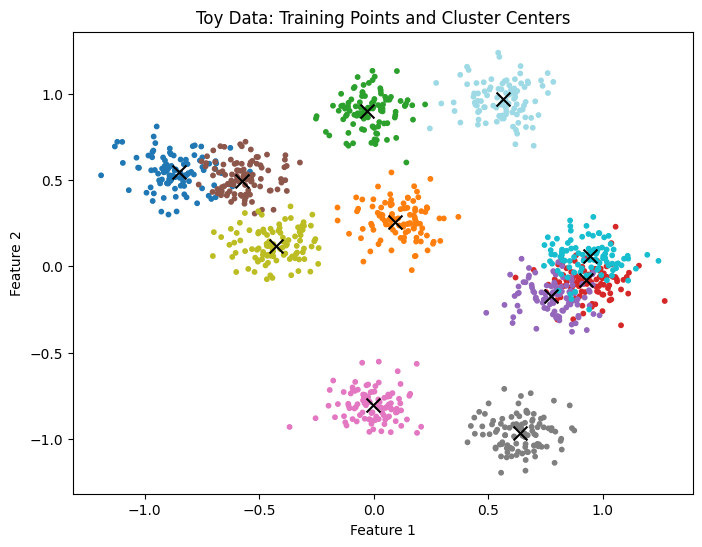

In [3]:
# Visualize toy data
X_train, X_test, y_train, y_test, centers = generate_toy_data()
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='tab20', s=10)
plt.scatter(centers[:, 0], centers[:, 1], c='black', marker='x', s=100)
plt.title("Toy Data: Training Points and Cluster Centers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Applying Linear PCA

Below, we fit a standard PCA model to the training data and transform the test data for reconstruction.


In [4]:
def fit_linear_pca(X):
    """
    Given data X of shape (n_samples, n_features),
    compute the mean and principal axes (V).
    Returns mean_X, and the matrix of principal axes V 
    (with shape (n_features, n_features)).
    """
    # 1) Center the data
    mean_X = np.mean(X, axis=0)
    X_centered = X - mean_X
    
    # 2) Compute SVD on the centered data
    #    X_centered = U * S * Vt  so V = Vt.T
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    V = Vt.T  # principal axes as columns
    
    return mean_X, V

def linear_pca_reconstruct(X, mean_X, V, n_components):
    """
    Reconstruct X using the first n_components of the
    principal axes V. Assumes V is shape (d, d) and mean_X shape (d,).
    
    1) Center X by subtracting mean_X
    2) Project onto first n_components principal axes
    3) Map back (inverse transform)
    """
    # Center
    X_centered = X - mean_X
    
    # Keep only top n_components axes
    # principal axes are the first n_components columns of V
    V_reduced = V[:, :n_components]  # shape (d, n_components)
    
    # Project onto the subspace
    X_projected = X_centered @ V_reduced  # shape (n_samples, n_components)
    
    # Reconstruct
    X_reconstructed = X_projected @ V_reduced.T + mean_X
    
    return X_reconstructed


### Applying Kernel PCA

We now apply Kernel PCA using an RBF (Gaussian) kernel. 
We now implement kernel PCA using the Gaussian (RBF) kernel:

1. **Kernel Computation:** For a data matrix $X$ and parameter $c$,
   $$
     K_{ij} = \exp\left(-\frac{\|x_i - x_j\|^2}{c}\right).
   $$

2. **Centering the Kernel:** We center $K$ in feature space.

3. **Eigen-decomposition:** We compute the eigenvalues and eigenvectors of the centered kernel.

4. **Pre-image Reconstruction:** Since the mapping is implicit, we use a fixed-point iteration
   to approximate the inverse mapping (the “pre-image”) for each training point.
   
   For each training point $x$, we define the coefficients
   $$
     a_{ij} = \sum_{k=1}^m \frac{\alpha_{ik} \alpha_{jk}}{\lambda_k},
   $$
   where $\alpha_{ik}$ are components of the normalized eigenvectors.
   
   Then the pre-image is approximated by iterating:
   $$
     x^{(t+1)} = \frac{\sum_{j=1}^{n} a_{ij}\,k(x^{(t)},x_j)x_j}
                          {\sum_{j=1}^{n} a_{ij}\,k(x^{(t)},x_j)}.
   $$


In [5]:
def compute_kernel_matrix(X, c):
    d = X.shape[1]          # dimension
    sq_norms = np.sum(X**2, axis=1, keepdims=True)
    sq_dists = sq_norms + sq_norms.T - 2 * X @ X.T
    K = np.exp(-sq_dists / c)
    return K

def center_kernel_matrix(K):
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    return K_centered

def kernel_pca_fit(X, m, c):
    K = compute_kernel_matrix(X, c)
    K_centered = center_kernel_matrix(K)
    eigenvals, eigenvecs = eigh(K_centered)
    idx = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]
    lambdas = eigenvals[:m]
    alphas = eigenvecs[:, :m]
    A = alphas.dot(np.diag(1.0 / (lambdas + 1e-10))).dot(alphas.T)
    model = {
        "X": X, "c": c, "K": K, "K_centered": K_centered, 
        "lambdas": lambdas, "alphas": alphas, "A": A, "m": m
    }
    return model

def preimage_fixed_point(x_init, X_train, A_row, c, max_iter=100, tol=1e-6):
    x_est = x_init.copy()
    for i in range(max_iter):
        diffs = X_train - x_est
        dists = np.sum(diffs**2, axis=1)
        weights = np.exp(-dists / c)
        weighted = A_row * weights
        numerator = np.sum(weighted[:, None] * X_train, axis=0)
        denominator = np.sum(weighted) + 1e-10
        x_new = numerator / denominator
        if norm(x_new - x_est) < tol:
            break
        x_est = x_new
    return x_est

def kernel_pca_reconstruct(X_input, model, init="same", max_iter=100, tol=1e-6):
    """
    Reconstruct points X_input (could be training or new points) using the kernel PCA model 
    and pre-image estimation via fixed-point iteration.
    
    Parameters:
      X_input (ndarray): Points to reconstruct, shape (n_samples, d).
      model (dict): Output from kernel_pca_fit (has alphas, lambdas, X, c, etc.).
      init (str): How to choose initial guesses for the pre-image iteration.
                  "same" means start from X_input[i] itself, or "zero" or a random vector, etc.
      max_iter (int), tol (float): Parameters for the fixed-point iteration.

    Returns:
      X_rec (ndarray): Reconstructed points, shape (n_samples, d).
    """
    X_train = model["X"]        # training data
    c = model["c"]
    alphas = model["alphas"]    # shape (n_samples, m)
    lambdas = model["lambdas"]  # length m
    K_train_centered = model["K_centered"]  # might or might not be needed directly
    
    # 1) Compute kernel vector for each new input wrt training set
    #    kappa(x) = [k(x, X_1), k(x, X_2), ..., k(x, X_n)]
    #    Then center it the same way we centered K.
    n_train = X_train.shape[0]
    K_input = np.zeros((X_input.shape[0], n_train))
    
    for i, x in enumerate(X_input):
        diffs = X_train - x
        dists = np.sum(diffs**2, axis=1)
        K_input[i] = np.exp(-dists / (X_train.shape[1] * c))  # same kernel form
    
    # 2) Center K_input consistently
    #    If K_centered = K - 1K - K1 + 1K1, then the "centered" row for x is
    #    kappa_centered(x) = kappa(x) - 1/n * sum_{j} kappa_j - ...
    one_n = np.ones((n_train,)) / n_train
    # mean of columns in K is  (1/n) * K_input.sum(axis=1)
    # but to keep consistent with the earlier approach, you might want to store the train-sum in the model 
    row_mean = np.mean(model["K"], axis=1)      # shape (n_train,)
    total_mean = np.mean(model["K"])            # scalar
    # For each row i: K_input[i] -> K_input[i] - row_mean - K_train_mean[i] + total_mean
    for i in range(K_input.shape[0]):
        K_input[i] -= row_mean
        K_input[i] -= np.mean(K_input[i])
        K_input[i] += total_mean

    # 3) Get the feature-space coordinates: alpha_i^T * K_input[i] / sqrt(lambda_i)
    #    Actually for reconstruction we want the sum over i=1..m of alpha_i * (that coefficient).
    #    Then we multiply by 1/lambda_i to get the reconstruction expansion A_row. 
    #    A_row for x is sum_{k=1..m} alpha_k ( [kappa_centered(x) . alpha_k] / lambda_k ).
    #    So we can build that vector directly:
    #    A_row = alpha * diag(1/lambda) * alpha^T * kappa_centered(x).
    #    But we already have A = alpha diag(1/lambda) alpha^T for the training set only,
    #    so let's just do the direct approach for each new x.
    
    A_rows = []
    for i in range(K_input.shape[0]):
        # project kappa_centered(x_i) onto alpha_k
        proj = alphas.T @ K_input[i]  # shape (m,)
        # multiply each proj[k] by 1/lambda_k, then expand in the basis of training points
        # => A_row = sum_k (proj[k]/lambda_k) alpha_k
        # But alpha_k is the k-th column of "alphas", so:
        # alphas shape: (n_train, m)
        # proj/lambdas shape: (m,)
        A_row = alphas @ ((proj) / (lambdas + 1e-10))
        A_rows.append(A_row)
    A_rows = np.array(A_rows)  # shape (n_samples, n_train)
    
    # 4) Pre-image for each row
    X_rec = np.zeros_like(X_input)
    for i in range(X_input.shape[0]):
        if init == "same":
            x0 = X_input[i]
        elif init == "zero":
            x0 = np.zeros_like(X_input[i])
        else:
            x0 = np.random.randn(*X_input[i].shape)
        
        X_rec[i] = preimage_fixed_point(
            x_init=x0,
            X_train=X_train,
            A_row=A_rows[i],
            c=c,
            max_iter=max_iter,
            tol=tol
        )
    
    return X_rec


### Experiment: Comparing Reconstruction Errors
For several noise levels and numbers of principal components, we:

1. Add noise to the clean data.
2. Reconstruct the data using linear PCA.
3. Reconstruct the data using kernel PCA.
4. Compute the mean squared reconstruction error (MSE) with respect to the clean data.
5. Form a performance ratio (kernel PCA error / linear PCA error).

You can adjust the list of noise standard deviations and the number of components tested.

Performance Ratios (Linear PCA Error / Kernel PCA Error):


Num Components,1,2,3,4,5,6,7,8,9
Noise Std,,,,,,,,,
0.05,940.559438,612.255306,343.420108,190.937146,105.300443,54.776308,16.499851,8.095358,6.223777
0.10,95.020133,63.828276,44.018088,30.616069,18.752237,12.080753,6.892118,4.999021,4.849248
0.20,26.282377,16.950755,11.456686,8.164022,5.640478,3.643452,4.050365,4.271552,4.506775
0.40,3.701571,2.071219,1.608,1.744234,1.400343,1.913457,2.219816,2.760184,3.137178
0.80,0.609121,0.787176,0.97987,1.11989,1.380818,1.891998,2.233936,2.555409,2.860417


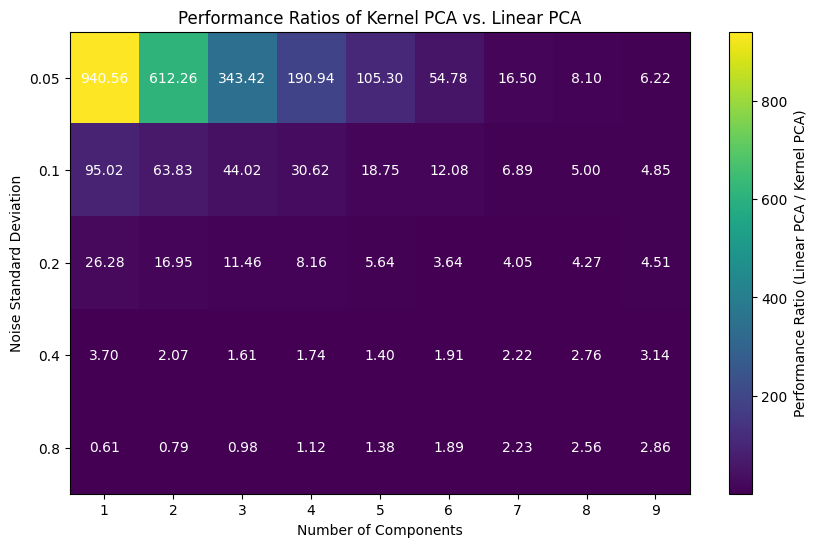

In [6]:
# Define the sigmas (noise_stds) and number of components (as before)
noise_stds = [0.05, 0.1, 0.2, 0.4, 0.8]
components_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]

results = pd.DataFrame(index=noise_stds, columns=components_list)

for sigma in noise_stds:
    # Generate the train/test data for this sigma
    X_train, X_test, y_train, y_test, centers = generate_toy_data(
        num_clusters=11, d=10, sigma=sigma,
        n_train=100, n_test=33, rng_seed=None
    )
    
    for m in components_list:
        # --- 1) Linear PCA fit on the training set ---
        mean_X, V = fit_linear_pca(X_train)
        
        # Reconstruct each test point
        X_rec_lin = linear_pca_reconstruct(X_test, mean_X, V, m)
        
        # Compute MSE of the reconstructed test point to its cluster center
        # for each test sample
        mse_lin = 0.0
        for i in range(len(X_test)):
            cluster_idx = y_test[i]
            mse_lin += np.sum((X_rec_lin[i] - centers[cluster_idx])**2)
        mse_lin /= len(X_test)
        
        # --- 2) Kernel PCA fit on the training set ---
        # Paper used c = 2*sigma^2 for the toy data
        c_param = 2 * (sigma**2)
        model = kernel_pca_fit(X_train, m, c=c_param)
        
        # Reconstruct the test set
        X_rec_kpca = kernel_pca_reconstruct(X_test, model)
        
        # Compute MSE of the reconstructed test point to its cluster center
        mse_kpca = 0.0
        for i in range(len(X_test)):
            cluster_idx = y_test[i]
            mse_kpca += np.sum((X_rec_kpca[i] - centers[cluster_idx])**2)
        mse_kpca /= len(X_test)
        
        # Store the ratio (linear PCA MSE) / (kernel PCA MSE)
        ratio = mse_lin / (mse_kpca + 1e-10)
        results.loc[sigma, m] = ratio

# Now display your table as usual
results.index.name = 'Noise Std'
results.columns.name = 'Num Components'
print("Performance Ratios (Linear PCA Error / Kernel PCA Error):")
display(results)

# Table as a heatmap
plt.figure(figsize=(10, 6))
plt.imshow(results.astype(float), cmap='viridis', aspect='auto')
plt.colorbar(label='Performance Ratio (Linear PCA / Kernel PCA)')
# Add numeric notation for each cell
for i in range(len(noise_stds)):
    for j in range(len(components_list)):
        plt.text(j, i, f"{results.values[i, j]:.2f}", ha='center', va='center', color='white')
plt.xlabel('Number of Components')
plt.ylabel('Noise Standard Deviation')
plt.title('Performance Ratios of Kernel PCA vs. Linear PCA')
plt.xticks(range(len(components_list)), components_list)
plt.yticks(range(len(noise_stds)), noise_stds)
plt.show()

We compare the results with the ones present on the Mika 1998 paper

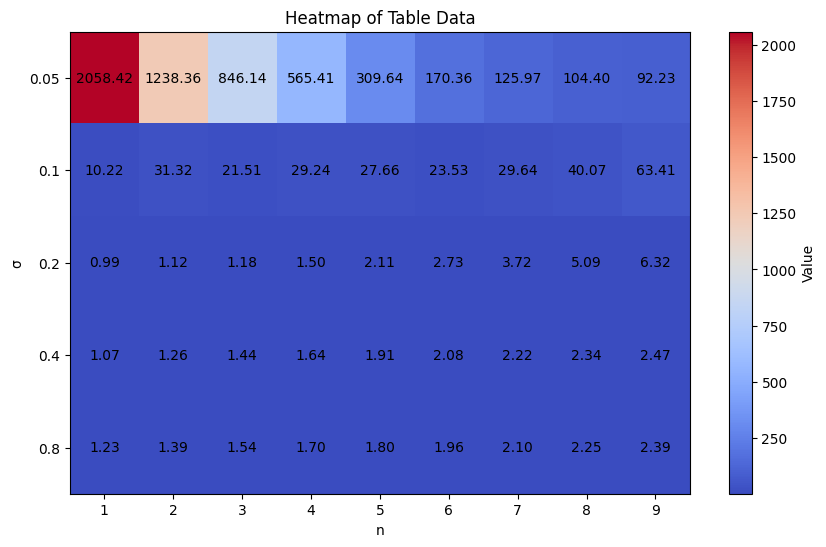

In [7]:
# Data from the table
data = np.array([
    [2058.42, 1238.36, 846.14, 565.41, 309.64, 170.36, 125.97, 104.40, 92.23],
    [10.22, 31.32, 21.51, 29.24, 27.66, 23.53, 29.64, 40.07, 63.41],
    [0.99, 1.12, 1.18, 1.50, 2.11, 2.73, 3.72, 5.09, 6.32],
    [1.07, 1.26, 1.44, 1.64, 1.91, 2.08, 2.22, 2.34, 2.47],
    [1.23, 1.39, 1.54, 1.70, 1.80, 1.96, 2.10, 2.25, 2.39]
])

# Row and column labels
sigma_values = [0.05, 0.1, 0.2, 0.4, 0.8]
n_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create DataFrame
df = pd.DataFrame(data, index=sigma_values, columns=n_values)

# Plot heatmap using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(df, aspect="auto", cmap="coolwarm")
plt.colorbar(label="Value")
plt.xticks(ticks=np.arange(len(n_values)), labels=n_values)
plt.yticks(ticks=np.arange(len(sigma_values)), labels=sigma_values)
plt.xlabel("n")
plt.ylabel("σ")
plt.title("Heatmap of Table Data")

# Annotate each cell with its numeric value
for i in range(len(sigma_values)):
    for j in range(len(n_values)):
        plt.text(j, i, f"{df.iloc[i, j]:.2f}",
                 ha="center", va="center", color="black")

plt.show()


## Data Generation: Arc and Square in 2D
We generate two one-dimensional curves in $\mathbb{R}^2$:
- **Arc:** Points along a circular arc.
- **Square:** Points along the perimeter of a square.
These two sets are then concatenated to form our clean data. We later add Gaussian noise.

### Functions needed

In [8]:
def generate_arc(n_points=100, radius=1.0, theta_start=0, theta_end=np.pi, gap_fraction=0.2):
    # Remove a gap in the middle of the arc.
    total_theta = theta_end - theta_start
    gap = total_theta * gap_fraction
    theta_mid = (theta_start + theta_end) / 2
    gap_start = theta_mid - gap / 2
    gap_end = theta_mid + gap / 2
    
    # Split points into two segments: before and after the gap.
    n_points_first = n_points // 2
    n_points_second = n_points - n_points_first
    theta1 = np.linspace(theta_start, gap_start, n_points_first, endpoint=False)
    theta2 = np.linspace(gap_end, theta_end, n_points_second)
    theta = np.concatenate([theta1, theta2])
    
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return np.column_stack([x, y])

def generate_square(n_points_per_edge=25, side=2.0):
    # Square centered at (0,0) with given side length.
    half = side / 2
    # Bottom edge: (-half,-half) to (half,-half)
    x_bottom = np.linspace(-half, half, n_points_per_edge)
    y_bottom = -half * np.ones(n_points_per_edge)
    # Right edge: (half,-half) to (half,half)
    y_right = np.linspace(-half, half, n_points_per_edge)
    x_right = half * np.ones(n_points_per_edge)
    # Top edge: (half,half) to (-half,half)
    x_top = np.linspace(half, -half, n_points_per_edge)
    y_top = half * np.ones(n_points_per_edge)
    # Left edge: (-half,half) to (-half,-half)
    y_left = np.linspace(half, -half, n_points_per_edge)
    x_left = -half * np.ones(n_points_per_edge)
    
    x = np.concatenate([x_bottom, x_right, x_top, x_left])
    y = np.concatenate([y_bottom, y_right, y_top, y_left])
    return np.column_stack([x, y])


### Plots to test the functions

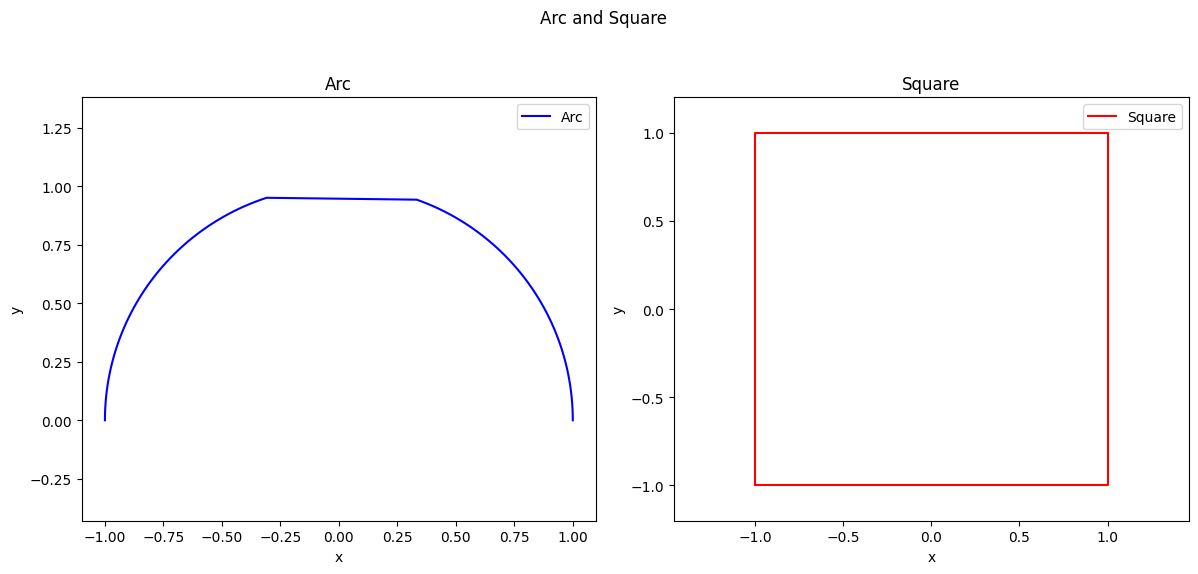

In [9]:
# Plot arc and square on same window
arc = generate_arc(n_points=100, radius=1.0, theta_start=0, theta_end=np.pi)
square = generate_square(n_points_per_edge=25, side=2.0)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot arc
axs[0].plot(arc[:, 0], arc[:, 1], label="Arc", color='blue')
axs[0].set_title("Arc")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].axis('equal')
axs[0].legend()

# Plot square
axs[1].plot(square[:, 0], square[:, 1], label="Square", color='red')
axs[1].set_title("Square")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].axis('equal')
axs[1].legend()

plt.suptitle("Arc and Square")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### De noising test

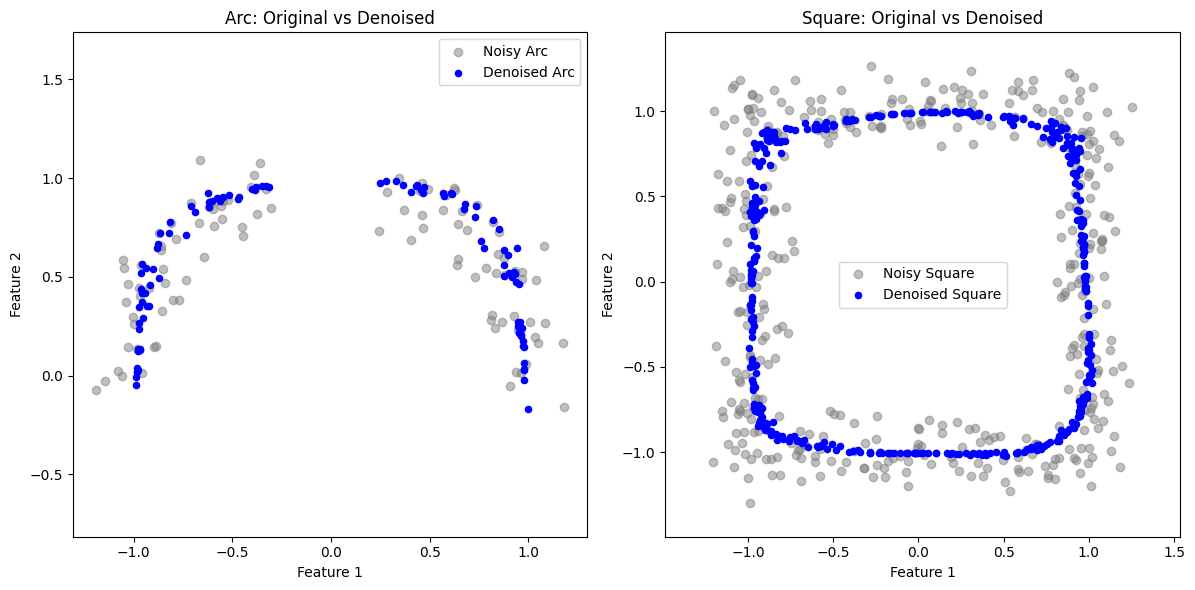

In [10]:
# 1) Generate the "arc + square" clean data in 2D
arc = generate_arc(n_points=100, radius=1.0)
square = generate_square(n_points_per_edge=100, side=2.0)
X_clean = np.vstack([arc, square])

# 2) Add Gaussian noise
noise_std = 0.1
X_noisy = X_clean + noise_std * np.random.randn(*X_clean.shape)

# 3) Choose the kernel PCA hyperparameters
m = 9               # number of components to keep
c_param = 0.4       # RBF kernel parameter (no dimension factor)

# 4) Fit Kernel PCA on the noisy data
model = kernel_pca_fit(X_noisy, m, c=c_param)

# 5) Reconstruct (denoise) the same noisy data
X_denoised = kernel_pca_reconstruct(X_noisy, model, init="same")

# 6) Separate the arc and square parts (arc first 100 rows, square next 100 rows)
arc_noisy    = X_noisy[:100]
arc_denoised = X_denoised[:100]
square_noisy    = X_noisy[100:]
square_denoised = X_denoised[100:]

# 7) Plotting both denoising results side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Arc
axs[0].scatter(arc_noisy[:, 0], arc_noisy[:, 1], color='gray', alpha=0.5, label='Noisy Arc')
axs[0].scatter(arc_denoised[:, 0], arc_denoised[:, 1], color='blue', s=20, label='Denoised Arc')
axs[0].set_title("Arc: Original vs Denoised")
axs[0].set_xlabel("Feature 1")
axs[0].set_ylabel("Feature 2")
axs[0].axis('equal')
axs[0].legend()

# Plot Square
axs[1].scatter(square_noisy[:, 0], square_noisy[:, 1], color='gray', alpha=0.5, label='Noisy Square')
axs[1].scatter(square_denoised[:, 0], square_denoised[:, 1], color='blue', s=20, label='Denoised Square')
axs[1].set_title("Square: Original vs Denoised")
axs[1].set_xlabel("Feature 1")
axs[1].set_ylabel("Feature 2")
axs[1].axis('equal')
axs[1].legend()

plt.tight_layout()
plt.show()


### Hyper parameters optimization using Optuna (Optional)

In [11]:
def objective(trial):
    # Suggest hyperparameters
    m = trial.suggest_int("m", 1, 100)
    c_param = trial.suggest_float("c_param", 0.01, 1.5, log=True)
    
    # Re-fit Kernel PCA with these hyperparams
    model = kernel_pca_fit(X_noisy, m, c=c_param)
    X_denoised = kernel_pca_reconstruct(X_noisy, model, init="same")
    
    # Compute the MSE to the clean data (arc + square)
    mse = np.mean(np.sum((X_denoised - X_clean)**2, axis=1))
    
    return mse

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Print and retrieve best trial
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (MSE): {best_trial.value}")
print(f"  Params: {best_trial.params}")

optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()


[I 2025-02-21 16:17:23,333] A new study created in memory with name: no-name-16d48780-57f5-42b8-b28a-fd0f2f6cd13e
[I 2025-02-21 16:17:23,791] Trial 0 finished with value: 0.01790753788147159 and parameters: {'m': 72, 'c_param': 0.018195253630028507}. Best is trial 0 with value: 0.01790753788147159.
[I 2025-02-21 16:17:24,288] Trial 1 finished with value: 0.03906072355418579 and parameters: {'m': 14, 'c_param': 0.022915938976261166}. Best is trial 0 with value: 0.01790753788147159.
[I 2025-02-21 16:17:24,680] Trial 2 finished with value: 0.01804822344363945 and parameters: {'m': 49, 'c_param': 0.13897156034343544}. Best is trial 0 with value: 0.01790753788147159.
[I 2025-02-21 16:17:25,038] Trial 3 finished with value: 0.014931107550643708 and parameters: {'m': 27, 'c_param': 0.17316117334124256}. Best is trial 3 with value: 0.014931107550643708.
[I 2025-02-21 16:17:25,426] Trial 4 finished with value: 0.017649924348365716 and parameters: {'m': 57, 'c_param': 0.08458960063640253}. Best 

Best trial:
  Value (MSE): 0.01281866562176014
  Params: {'m': 16, 'c_param': 0.18183840374304652}


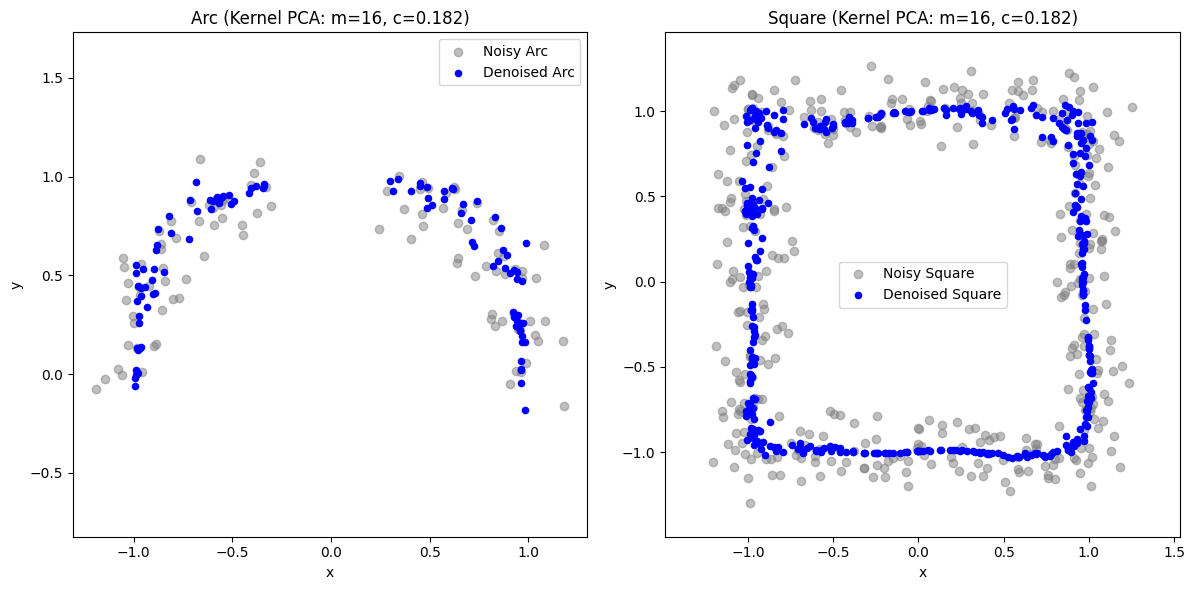

In [12]:
# Use the best hyperparameters from the study
best_trial = study.best_trial
m_best = best_trial.params["m"]
c_best = best_trial.params["c_param"]

# Refit Kernel PCA on the noisy "arc + square" data using best hyperparameters
model_best = kernel_pca_fit(X_noisy, m_best, c=c_best)
X_denoised_best = kernel_pca_reconstruct(X_noisy, model_best, init="same")

# Separate the denoised outputs for arc and square
arc_noisy_best = X_noisy[:100] 
arc_denoised_best = X_denoised_best[:100]
square_noisy_best = X_noisy[100:]
square_denoised_best = X_denoised_best[100:]

# Plotting the arc and square with their denoised versions
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Arc
axs[0].scatter(arc_noisy_best[:, 0], arc_noisy_best[:, 1], color='gray', alpha=0.5, label='Noisy Arc')
axs[0].scatter(arc_denoised_best[:, 0], arc_denoised_best[:, 1], color='blue', s=20, label='Denoised Arc')
axs[0].set_title(f"Arc (Kernel PCA: m={m_best}, c={c_best:.3f})")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].axis('equal')
axs[0].legend()

# Plot Square
axs[1].scatter(square_noisy_best[:, 0], square_noisy_best[:, 1], color='gray', alpha=0.5, label='Noisy Square')
axs[1].scatter(square_denoised_best[:, 0], square_denoised_best[:, 1], color='blue', s=20, label='Denoised Square')
axs[1].set_title(f"Square (Kernel PCA: m={m_best}, c={c_best:.3f})")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].axis('equal')
axs[1].legend()

plt.tight_layout()
plt.show()

### Nonlinear Autoencoder De-noising
We build a simple autoencoder with a 1-dimensional bottleneck using Keras.
The network is trained to map the noisy input to the clean target.
To order the reconstructions into a smooth curve we also extract the bottleneck (encoded) values.

In [13]:
# 1) Generate your arc + square (or do them separately).
#    For demonstration, let's do them separately so we can plot them in 2x2 each.
arc_clean = generate_arc(n_points=200, radius=1.0)
square_clean = generate_square(n_points_per_edge=200, side=2.0)

noise_std = 0.1
arc_noisy = arc_clean + noise_std * np.random.randn(*arc_clean.shape)
square_noisy = square_clean + noise_std * np.random.randn(*square_clean.shape)

# 2) Linear PCA Denoising function
def denoise_linear_pca(X_noisy, n_components=2):
    mean_X, V = fit_linear_pca(X_noisy)
    return linear_pca_reconstruct(X_noisy, mean_X, V, n_components)

# 3) Kernel PCA Denoising function
def denoise_kernel_pca(X_noisy, m=5, c_param=0.4):
    model = kernel_pca_fit(X_noisy, m, c=c_param)
    return kernel_pca_reconstruct(X_noisy, model, init="same")

# 4) Autoencoder builder
def build_autoencoder(input_dim=2, encoding_dim=1):
    input_layer = keras.Input(shape=(input_dim,))
    encoded = layers.Dense(10, activation='relu')(input_layer)
    bottleneck = layers.Dense(encoding_dim, activation='linear', name='bottleneck')(encoded)
    decoded = layers.Dense(10, activation='relu')(bottleneck)
    output_layer = layers.Dense(input_dim, activation='linear')(decoded)
    autoencoder = keras.Model(inputs=input_layer, outputs=output_layer)
    encoder = keras.Model(inputs=input_layer, outputs=bottleneck)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

def denoise_autoencoder(X_noisy, X_clean, encoding_dim=1, epochs=500):
    autoencoder, encoder = build_autoencoder(input_dim=2, encoding_dim=encoding_dim)
    autoencoder.fit(X_noisy, X_clean, epochs=epochs, batch_size=16, verbose=0)
    return autoencoder.predict(X_noisy)


In [14]:
# 5) Compare 3 methods on Square (no principal curves)
square_lin   = denoise_linear_pca(square_noisy, n_components=1)
square_kpca  = denoise_kernel_pca(square_noisy, m=18, c_param=0.13)
square_auto  = denoise_autoencoder(square_noisy, square_clean, encoding_dim=1, epochs=1_000)

# 6) Compare 3 methods on Arc
arc_lin   = denoise_linear_pca(arc_noisy, n_components=1)
arc_kpca  = denoise_kernel_pca(arc_noisy, m=5, c_param=0.2)
arc_auto  = denoise_autoencoder(arc_noisy, arc_clean, encoding_dim=1, epochs=1_000)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


### Compare the three methods

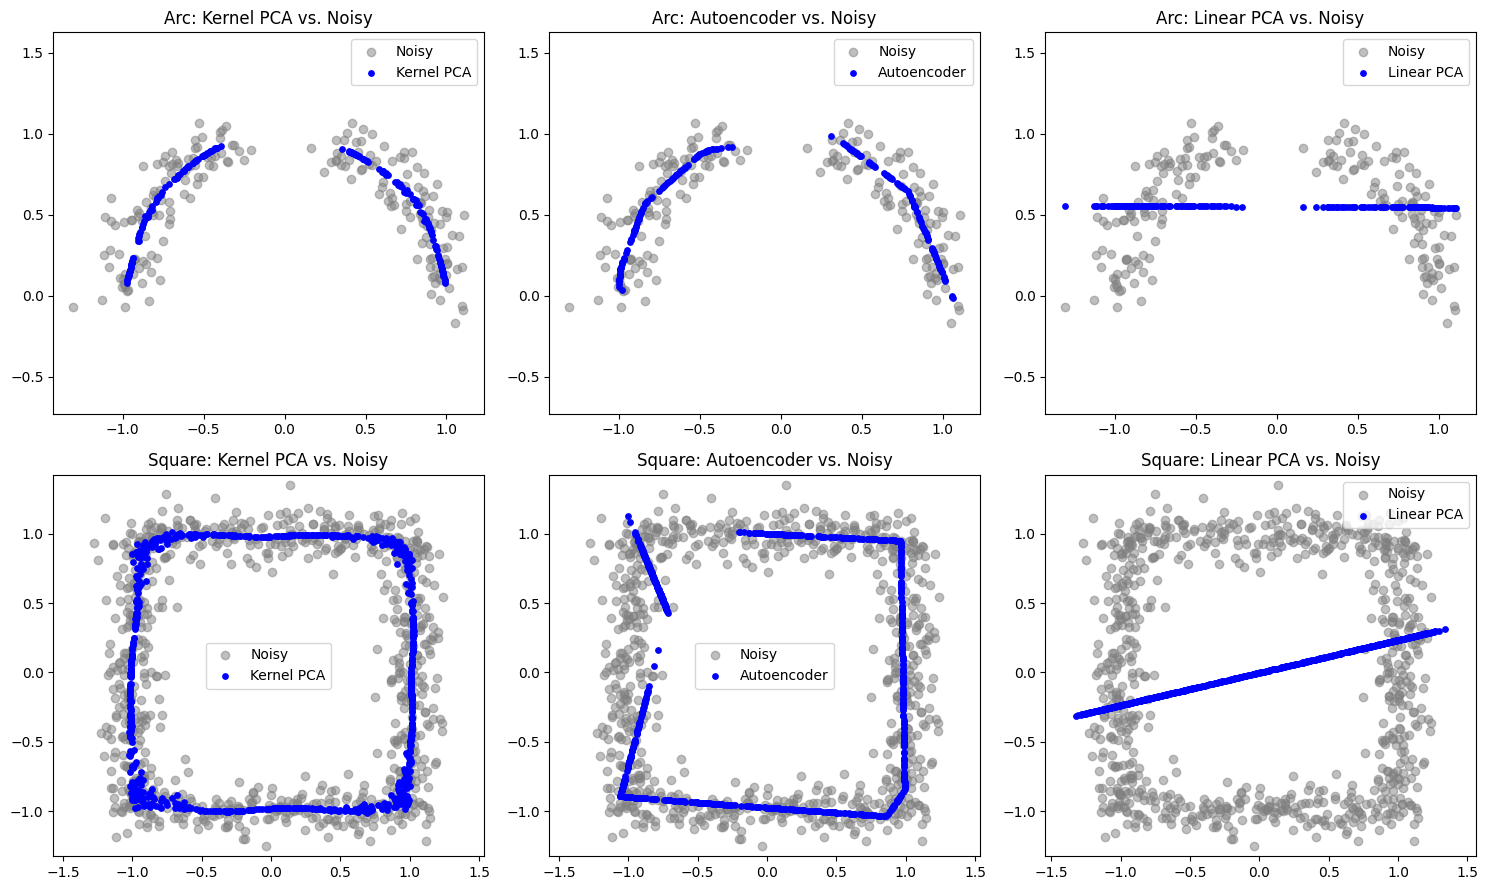

In [15]:
# Create a 2x3 subplot layout
fig, axs = plt.subplots(2, 3, figsize=(15, 9))

# First row: Arc plots
# Plot 1: Kernel PCA vs. Noisy
axs[0,0].scatter(arc_noisy[:,0], arc_noisy[:,1], color='gray', alpha=0.5, label='Noisy')
axs[0,0].scatter(arc_kpca[:,0], arc_kpca[:,1], color='blue', s=15, label='Kernel PCA')
axs[0,0].set_title("Arc: Kernel PCA vs. Noisy")
axs[0,0].axis('equal')
axs[0,0].legend()

# Plot 2: Autoencoder vs. Noisy
axs[0,1].scatter(arc_noisy[:,0], arc_noisy[:,1], color='gray', alpha=0.5, label='Noisy')
axs[0,1].scatter(arc_auto[:,0], arc_auto[:,1], color='blue', s=15, label='Autoencoder')
axs[0,1].set_title("Arc: Autoencoder vs. Noisy")
axs[0,1].axis('equal')
axs[0,1].legend()

# Plot 3: Linear PCA vs. Noisy
axs[0,2].scatter(arc_noisy[:,0], arc_noisy[:,1], color='gray', alpha=0.5, label='Noisy')
axs[0,2].scatter(arc_lin[:,0], arc_lin[:,1], color='blue', s=15, label='Linear PCA')
axs[0,2].set_title("Arc: Linear PCA vs. Noisy")
axs[0,2].axis('equal')
axs[0,2].legend()

# Second row: Square plots
# Plot 1: Kernel PCA vs. Noisy
axs[1,0].scatter(square_noisy[:,0], square_noisy[:,1], color='gray', alpha=0.5, label='Noisy')
axs[1,0].scatter(square_kpca[:,0], square_kpca[:,1], color='blue', s=15, label='Kernel PCA')
axs[1,0].set_title("Square: Kernel PCA vs. Noisy")
axs[1,0].axis('equal')
axs[1,0].legend()

# Plot 2: Autoencoder vs. Noisy
axs[1,1].scatter(square_noisy[:,0], square_noisy[:,1], color='gray', alpha=0.5, label='Noisy')
axs[1,1].scatter(square_auto[:,0], square_auto[:,1], color='blue', s=15, label='Autoencoder')
axs[1,1].set_title("Square: Autoencoder vs. Noisy")
axs[1,1].axis('equal')
axs[1,1].legend()

# Plot 3: Linear PCA vs. Noisy
axs[1,2].scatter(square_noisy[:,0], square_noisy[:,1], color='gray', alpha=0.5, label='Noisy')
axs[1,2].scatter(square_lin[:,0], square_lin[:,1], color='blue', s=15, label='Linear PCA')
axs[1,2].set_title("Square: Linear PCA vs. Noisy")
axs[1,2].axis('equal')
axs[1,2].legend()

plt.tight_layout()
plt.show()

## Load and Prepare the USPS Dataset
We load the USPS dataset from OpenML. USPS images are 16×16 (256 features).
For the kernel PCA part, we subsample the dataset for computational efficiency.

In [16]:
def pixel_significance_map(alpha_k, X_train, c, img_size=16):
    """
    Compute the 'pixel significance' image for a single kernel PCA eigenvector alpha_k.
    That is, for each pixel i in [0, 255], define e_i (the canonical basis vector),
    compute k(e_i, X_train_j), center it, then dot with alpha_k.

    Returns:
      significance (ndarray): shape (256,) with the significance for each pixel.
    """
    n_train = X_train.shape[0]
    
    # 1) Precompute train mean to do 'kernel centering' for each pixel basis
    K_train = compute_kernel_matrix(X_train, c)
    Kc_train = center_kernel_matrix(K_train)  # might not strictly be needed, but let's be consistent
    row_mean = np.mean(K_train, axis=1)       # shape (n_train,)
    total_mean = np.mean(K_train)             # scalar

    significance = np.zeros((img_size*img_size,), dtype=np.float64)
    
    for i in range(img_size*img_size):
        # e_i: a standard basis vector with 1 in index i, 0 otherwise
        # We'll do the RBF with the training set:
        diffs = X_train - np.eye(1, img_size*img_size, i)[0]  # shape (n_train, 256)
        dists = np.sum(diffs**2, axis=1)
        k_row = np.exp(-dists / c)  # shape (n_train,)

        # 2) Center this row the same way as K_centered
        #    k_row_centered = k_row - row_mean_of_that_row - ...
        # But we need the row_mean for 'k_row' specifically, and col_mean for each X_train_j
        # For simplicity, let's do the double-centering formula again:
        # Kc(i,j) = K(i,j) - 1/n sum_j K(i,j) - 1/n sum_i K(i,j) + 1/n^2 sum_{i,j} K(i,j)
        # but i is "pixel basis row", so:
        # => k_row_centered = k_row - average(k_row) - row_mean + total_mean / n
        # We'll do it carefully:

        row_mean_krow = np.mean(k_row)
        k_row_centered = k_row - row_mean_krow - row_mean + total_mean

        # 3) Dot with alpha_k
        val = np.dot(alpha_k, k_row_centered)
        significance[i] = val
    
    # Optional: normalize
    sig_min, sig_max = significance.min(), significance.max()
    if abs(sig_max - sig_min) > 1e-12:
        significance = (significance - sig_min) / (sig_max - sig_min)
    else:
        significance[:] = 0.0

    return significance.reshape(img_size, img_size)


### Linear PCA Eigenvector Visualization
We center the data, perform SVD, and extract the top 9 eigenvectors (principal directions).
These eigenvectors are naturally in the input space so we can reshape them into images.

### Kernel PCA Eigenvector Visualization
We now perform kernel PCA on a subsample of the USPS data.
We use the Gaussian (RBF) kernel:

$$
  K(x_i, x_j) = \exp\Big(-\frac{\|x_i - x_j\|^2}{c}\Big)
$$

The kernel parameter `c` is adjustable (here we set it to 1000.0; you may experiment with it).

After computing the kernel PCA eigen-decomposition, note that the principal components in feature space are
given implicitly by

$$
  v^{(k)} = \sum_{i} \alpha_{i}^{(k)}\, \phi(x_i),
$$

and we wish to visualize a corresponding “eigenimage” in the input space. We do this by approximating the pre-image.
We implement a fixed-point iteration to compute the pre-image for a given eigenvector, using two different
initializations.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

def demo_usps_eigenvectors_pixel_significance(
    n_eigs=9,
    c_param=20000.0,
    subsample_size=1000,
    random_state=None,
    max_iter=300
):
    """
    Show 3 rows:
      Row 1: Linear PCA eigenvectors
      Row 2: Kernel PCA pre-image (Method 1)
      Row 3: Kernel PCA pixel significance map
    """
    usps = fetch_openml('usps', version=2, as_frame=False)
    X_usps = usps.data.astype(np.float64) / 255.0

    rng = np.random.RandomState(random_state)
    subsample_indices = rng.choice(X_usps.shape[0], subsample_size, replace=False)
    X_sub = X_usps[subsample_indices]
    
    img_size = int(np.sqrt(X_sub.shape[1]))  # 16

    # --- Linear PCA
    X_centered = X_sub - X_sub.mean(axis=0)
    U, S, Vt = svd(X_centered, full_matrices=False)
    linear_eigs = Vt[:n_eigs]
    
    def normalize_image(vec):
        vec = vec - vec.min()
        vmax = vec.max()
        if vmax > 1e-12:
            vec /= vmax
        return vec

    linear_eigs_disp = np.array([normalize_image(v) for v in linear_eigs])

    # --- Kernel PCA
    model = kernel_pca_fit(X_sub, m=n_eigs, c=c_param)
    alphas = model["alphas"]   # shape (subsample_size, n_eigs)
    lambdas = model["lambdas"]
    X_train = model["X"]

    # Pre-image function
    def preimage_eigenvector(alpha, lam, X, c, x_init, max_iter=300, tol=1e-6):
        x_est = x_init.copy()
        weights_coeff = alpha / (lam + 1e-10)
        for _ in range(max_iter):
            dists = np.sum((X - x_est)**2, axis=1)
            w = np.exp(-dists / c)
            weighted = weights_coeff * w
            numerator = np.sum(weighted[:, None] * X, axis=0)
            denom = np.sum(weighted) + 1e-12
            x_new = numerator / denom
            if norm(x_new - x_est) < tol:
                break
            x_est = x_new
        return x_est
    
    # Method 1 pre-images
    kpca_preimages = []
    for k in range(n_eigs):
        alpha_k = alphas[:, k]
        lam_k = lambdas[k]
        sum_a = alpha_k.sum()
        if abs(sum_a) < 1e-12:
            # fallback
            init_vec = X_train.mean(axis=0) + 0.01*rng.randn(X_train.shape[1])
        else:
            init_vec = np.sum(alpha_k[:,None]*X_train, axis=0)/(sum_a+1e-12)
        preimg = preimage_eigenvector(alpha_k, lam_k, X_train, c_param, init_vec, max_iter=max_iter)
        kpca_preimages.append(normalize_image(preimg))

    # Pixel significance
    kpca_significance = []
    for k in range(n_eigs):
        alpha_k = alphas[:, k]
        sig_map = pixel_significance_map(alpha_k, X_train, c_param, img_size=img_size)
        kpca_significance.append(sig_map)

    # --- Plot 3 rows x n_eigs columns
    fig, axs = plt.subplots(3, n_eigs, figsize=(1.8*n_eigs, 6))
    fig.suptitle(f"USPS Kernel PCA vs Linear PCA\n(n_eigs={n_eigs}, c={c_param}, sub={subsample_size})")

    for i in range(n_eigs):
        # Row 1: Linear PCA
        axs[0, i].imshow(linear_eigs_disp[i].reshape(img_size, img_size), cmap='gray')
        axs[0, i].set_title(f"PC {i+1}")
        axs[0, i].axis('off')

        # Row 2: Kernel PCA pre-image
        axs[1, i].imshow(kpca_preimages[i].reshape(img_size, img_size), cmap='gray')
        axs[1, i].axis('off')

        # Row 3: Pixel significance
        axs[2, i].imshow(kpca_significance[i], cmap='gray')
        axs[2, i].axis('off')

    axs[0, 0].set_ylabel("Linear PCA")
    axs[1, 0].set_ylabel("Kernel PCA\nPre-image")
    axs[2, 0].set_ylabel("Kernel PCA\nPixel Significance")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


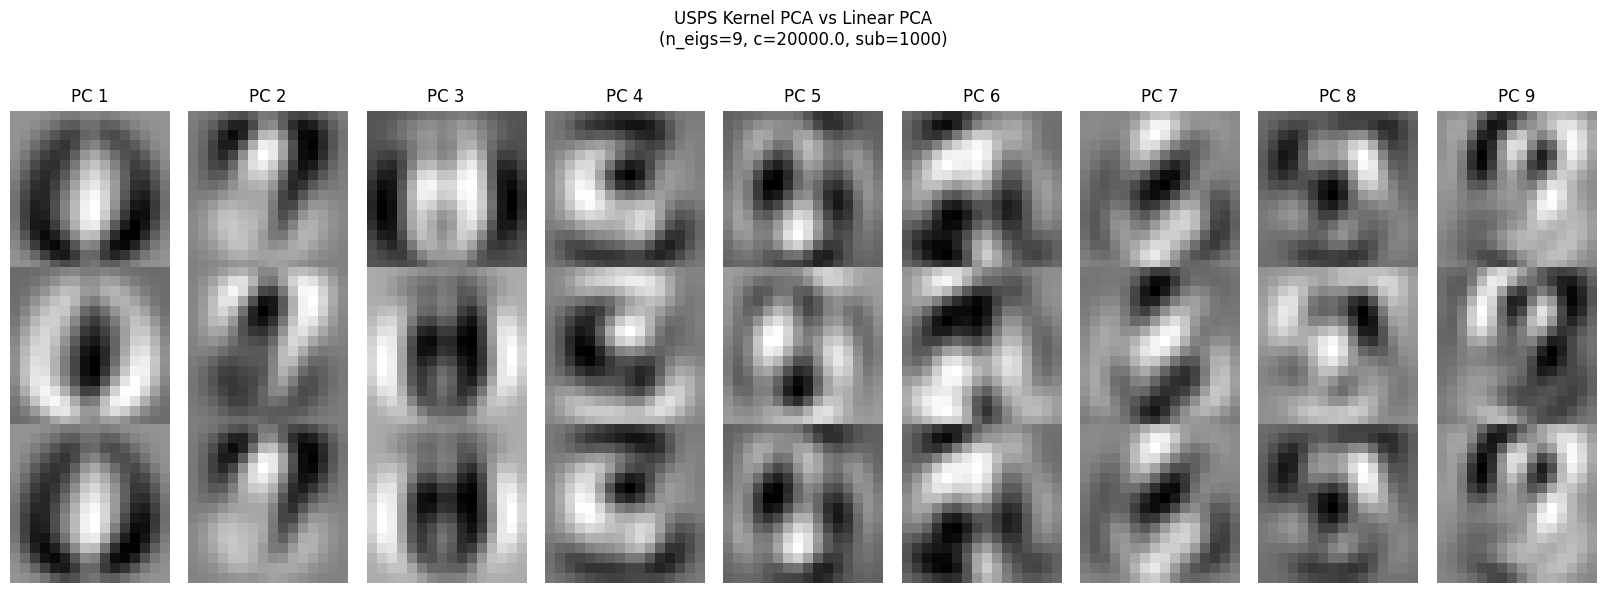

In [18]:
# Test the function
demo_usps_eigenvectors_pixel_significance(n_eigs=9, c_param=20000.0, subsample_size=1000, random_state=42, max_iter=300)


### Load USPS and Filter Digit “3”
We load the USPS dataset from OpenML and extract only the images corresponding to the digit "3."
The images are 16×16 (i.e. 256 features).

### Experiment: Reconstructing a Digit “3” with Increasing Components
For each number of components $m = 1,\dots,20$, we:
- Reconstruct the chosen target digit using linear PCA.
- Reconstruct the target digit using kernel PCA (with a fixed kernel parameter).
- Compute the error fraction for each reconstruction.

We store the reconstructions and error fractions for visualization.

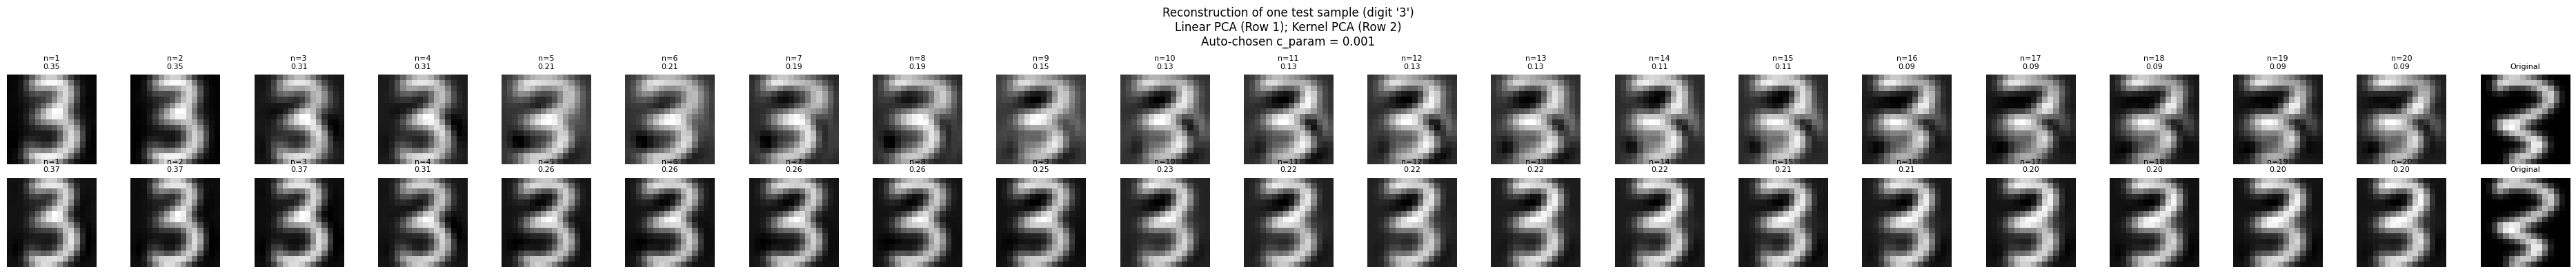

In [22]:
# ------------------------------
# 1) LINEAR PCA
# ------------------------------
def fit_linear_pca(X):
    mean_X = np.mean(X, axis=0)
    X_centered = X - mean_X
    U, S, Vt = svd(X_centered, full_matrices=False)
    V = Vt.T  # columns = principal directions
    return mean_X, V

def reconstruct_linear_pca(x, mean_X, V, n_components):
    x_centered = x - mean_X
    V_red = V[:, :n_components]
    coeffs = x_centered @ V_red
    x_recon = coeffs @ V_red.T + mean_X
    return x_recon

# ------------------------------
# 2) KERNEL PCA
# ------------------------------
def compute_kernel_matrix(X, c_param):
    sq_norms = np.sum(X**2, axis=1, keepdims=True)
    sq_dists = sq_norms + sq_norms.T - 2*X@X.T
    return np.exp(-sq_dists / c_param)

def center_kernel_matrix(K):
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    return K - one_n @ K - K @ one_n + one_n @ K @ one_n

def kernel_pca_fit(X, m, c_param):
    K = compute_kernel_matrix(X, c_param)
    Kc = center_kernel_matrix(K)
    vals, vecs = eigh(Kc)
    idx = np.argsort(vals)[::-1]
    vals = vals[idx][:m]
    vecs = vecs[:, idx][:, :m]
    col_mean = np.mean(Kc, axis=0)
    grand_mean = np.mean(Kc)
    return {
        "X": X,
        "c_param": c_param,
        "alphas": vecs,
        "lambdas": vals,
        "col_mean": col_mean,
        "grand_mean": grand_mean
    }

def kernel_pca_reconstruct_single(x, model, n_components, max_iter=50, tol=1e-7):
    X_train = model["X"]
    c_param = model["c_param"]
    alphas_full = model["alphas"]
    lambdas_full = model["lambdas"]
    col_mean = model["col_mean"]
    grand_mean = model["grand_mean"]

    alphas = alphas_full[:, :n_components]
    lambdas = lambdas_full[:n_components]

    diffs = X_train - x
    dists = np.sum(diffs**2, axis=1)
    k_row = np.exp(-dists / c_param)

    row_mean = np.mean(k_row)
    k_row_c = k_row - row_mean - col_mean + grand_mean

    proj = alphas.T @ k_row_c
    A_row = alphas @ (proj / (lambdas + 1e-12))

    x_est = x.copy()
    for _ in range(max_iter):
        dists_est = np.sum((X_train - x_est)**2, axis=1)
        w = np.exp(-dists_est / c_param)
        weighted = A_row * w
        numerator = np.sum(weighted[:, None] * X_train, axis=0)
        denom = np.sum(weighted) + 1e-12
        x_new = numerator / denom
        if norm(x_new - x_est) < tol:
            break
        x_est = x_new

    return x_est

# ------------------------------
# 3) DEMO: focusing on one digit ("3")
# ------------------------------
def replicate_figure_only_digit(n_max=20, random_state=42):
    usps = fetch_openml('usps', version=2, as_frame=False)
    X_all = usps.data.astype(np.float64) / 255.0
    y_all = usps.target

    # Filter for digit "3"
    mask_3 = (y_all == '4')
    X_3 = X_all[mask_3]
    # Use only the samples for digit "3" for both train and test
    X_train, X_test, _, _ = train_test_split(
        X_3, X_3, test_size=0.2, random_state=random_state
    )

    n_sub = min(1000, X_train.shape[0])
    idx_sub = np.random.choice(X_train.shape[0], size=n_sub, replace=False)
    X_sub = X_train[idx_sub]
    dists_sub = np.sum((X_sub[:, None, :] - X_sub[None, :, :])**2, axis=-1)
    avg_dist = np.mean(dists_sub)
    c_param_auto = avg_dist / 2.0

    # Fit models using training data
    mean_all, V_all = fit_linear_pca(X_train)
    model_kpca_all = kernel_pca_fit(X_train, m=n_max, c_param=c_param_auto)

    # Use the first test sample
    x_original = X_test[0]
    denom = norm(x_original)**2 + 1e-12

    recons_lin, recons_kpca = [], []
    fractions_lin, fractions_kpca = [], []
    for n in range(1, n_max+1):
        # Reconstruct using n components
        x_lin = reconstruct_linear_pca(x_original, mean_all, V_all, n)
        dist_lin = norm(x_lin - x_original)**2
        fractions_lin.append(dist_lin / denom)
        recons_lin.append(x_lin)

        x_kpca = kernel_pca_reconstruct_single(x_original, model_kpca_all, n)
        dist_kpca = norm(x_kpca - x_original)**2
        fractions_kpca.append(dist_kpca / denom)
        recons_kpca.append(x_kpca)

    fig, axs = plt.subplots(2, n_max+1, figsize=(1.8*(n_max+1), 4))
    fig.suptitle(
        "Reconstruction of one test sample (digit '3')\n"
        "Linear PCA (Row 1); Kernel PCA (Row 2)\n"
        f"Auto-chosen c_param = {c_param_auto:.3f}"
    )

    def show_digit(ax, x_vec, title=""):
        ax.imshow(x_vec.reshape(16, 16), cmap='gray', interpolation='nearest')
        ax.set_title(title, fontsize=8)
        ax.axis('off')

    for i in range(n_max):
        show_digit(axs[0, i], recons_lin[i], title=f"n={i+1}\n{fractions_lin[i]:.2f}")
    show_digit(axs[0, n_max], x_original, title="Original")
    axs[0, 0].set_ylabel("Linear PCA", fontsize=10)

    for i in range(n_max):
        show_digit(axs[1, i], recons_kpca[i], title=f"n={i+1}\n{fractions_kpca[i]:.2f}")
    show_digit(axs[1, n_max], x_original, title="Original")
    axs[1, 0].set_ylabel("Kernel PCA", fontsize=10)

    plt.tight_layout()
    plt.show()

# ------------------------------
# RUN THE DEMO
# ------------------------------
replicate_figure_only_digit(n_max=20, random_state=None)


### Compare gaussian and speckle noise

In this experiment, we compare de noising with different number of components and different values of $\sigma$ for both added gaussian or speckle noise

Unique labels in y_test: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
For digit '0', we picked test index = 24, actual label in y_test is '0'
For digit '1', we picked test index = 2, actual label in y_test is '1'
For digit '2', we picked test index = 4, actual label in y_test is '2'
For digit '3', we picked test index = 0, actual label in y_test is '3'
For digit '4', we picked test index = 41, actual label in y_test is '4'
For digit '5', we picked test index = 25, actual label in y_test is '5'
For digit '6', we picked test index = 3, actual label in y_test is '6'
For digit '7', we picked test index = 20, actual label in y_test is '7'
For digit '8', we picked test index = 1, actual label in y_test is '8'
For digit '9', we picked test index = 9, actual label in y_test is '9'
Fitting Linear PCA...
Fitting Kernel PCA (auto c_param from median distance)...


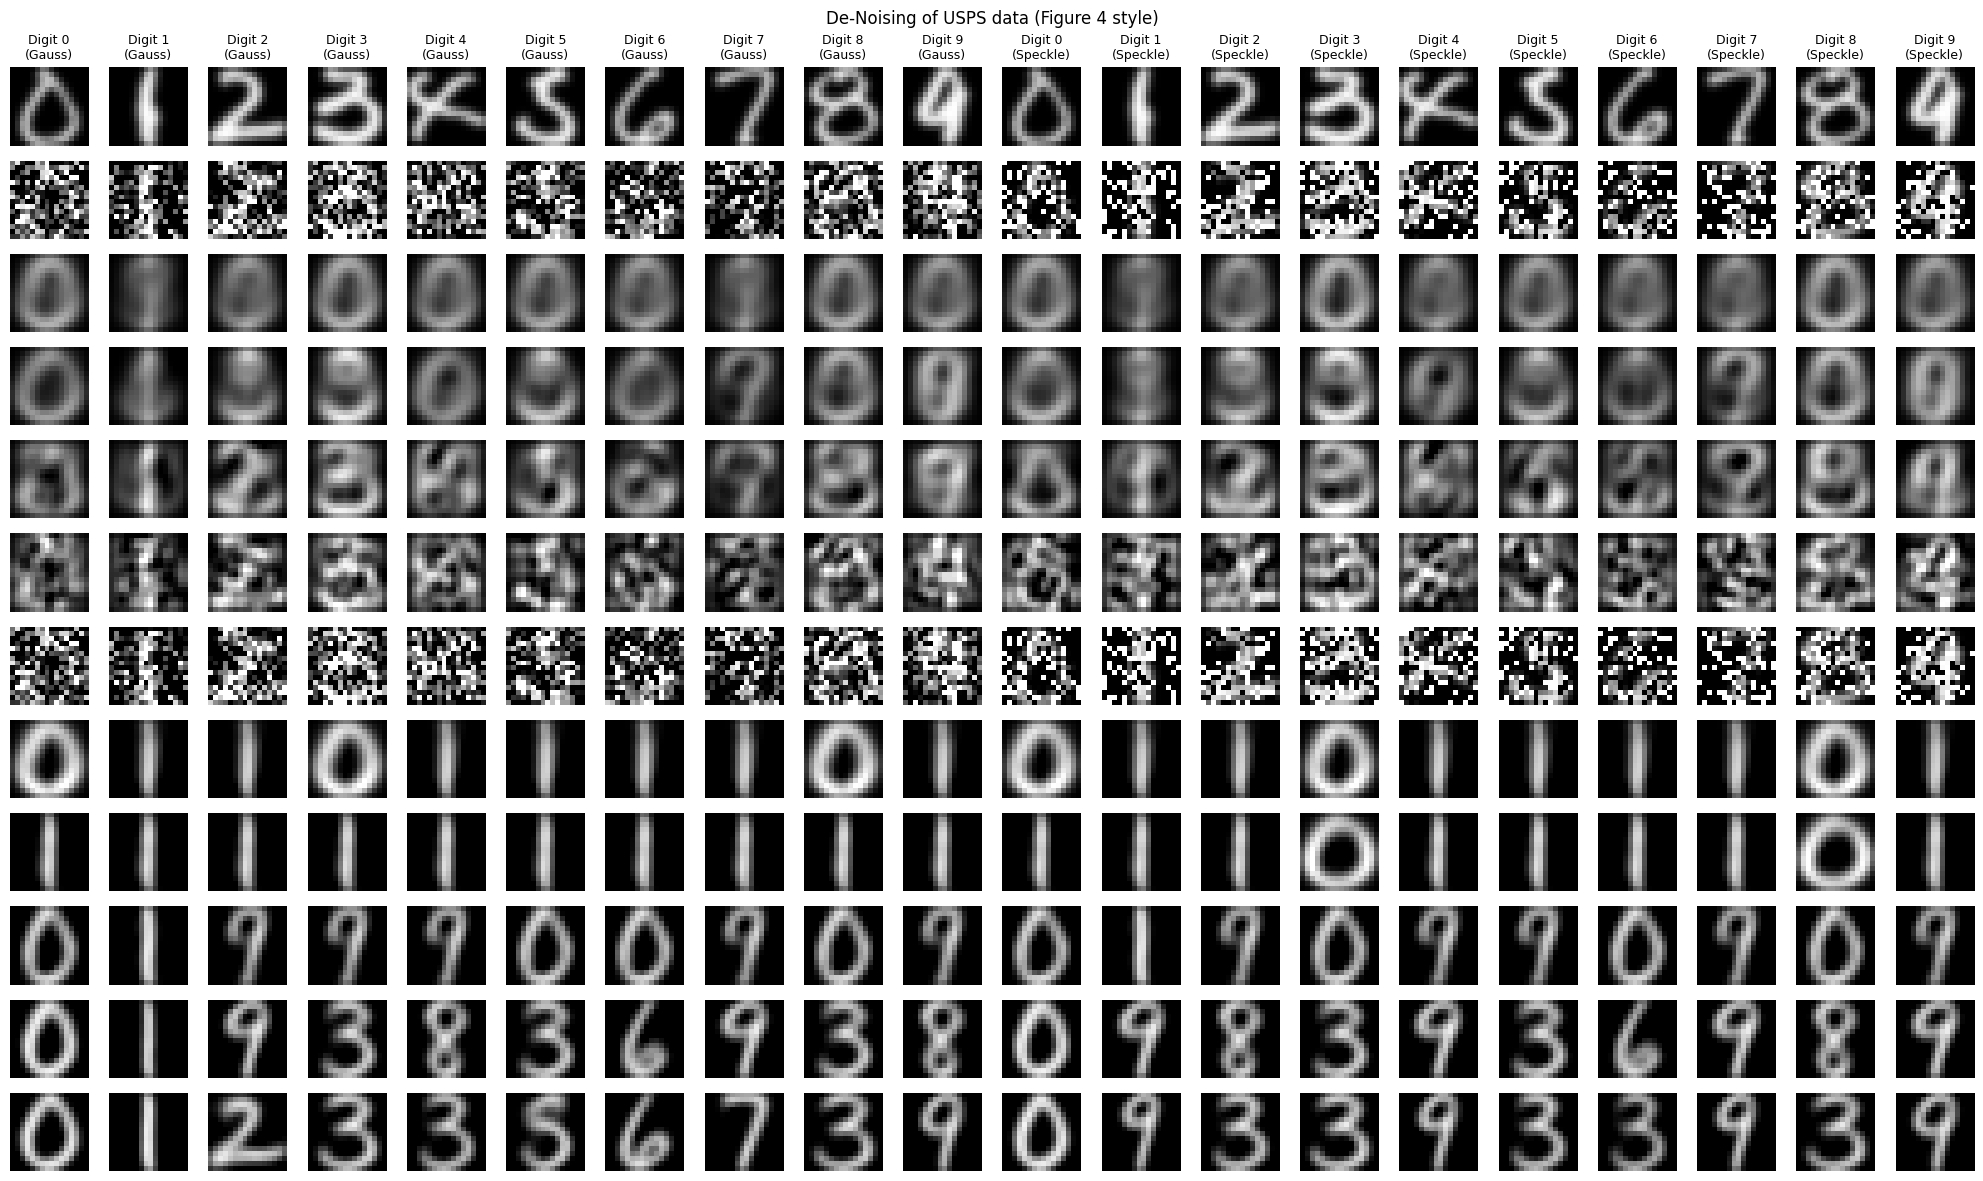

In [19]:
def preprocess_usps_data(X):
    """Normalize USPS data to [0, 1]."""
    X = X.astype(np.float64)
    return (X - X.min()) / (X.max() - X.min())

def add_gaussian_noise(x, sigma=0.5):
    return np.clip(x + sigma * np.random.randn(*x.shape), 0, 1)

def add_speckle_noise(x, p=0.4):
    x_noisy = x.copy()
    mask = np.random.rand(*x.shape)
    x_noisy[mask < p/2] = 0.0  # Set to black
    x_noisy[(mask >= p/2) & (mask < p)] = 1.0  # Set to white
    return x_noisy

def fit_linear_pca(X):
    mean_X = np.mean(X, axis=0)
    Xc = X - mean_X
    U, S, Vt = svd(Xc, full_matrices=False)
    return mean_X, Vt.T

def reconstruct_linear_pca(x, mean_X, V, n_components):
    """Reconstruct using linear PCA."""
    x_c = x - mean_X
    V_red = V[:, :n_components]
    coeffs = x_c @ V_red
    return coeffs @ V_red.T + mean_X

def compute_kernel_matrix(X, c_param):
    sq_norms = np.sum(X**2, axis=1)
    sq_dists = sq_norms[:, None] + sq_norms[None, :] - 2 * X @ X.T
    return np.exp(-sq_dists / c_param)

def center_kernel_matrix(K):
    """Center the kernel matrix."""
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    return K - one_n @ K - K @ one_n + one_n @ K @ one_n

def kernel_pca_fit(X, m, c_param=None):
    if c_param is None:
        c_param = np.median(pairwise_distances(X)) ** 2
    K = compute_kernel_matrix(X, c_param)
    Kc = center_kernel_matrix(K)
    vals, vecs = eigh(Kc)
    idx = np.argsort(vals)[::-1][:m]
    return {"X": X, "c_param": c_param, "alphas": vecs[:, idx], "lambdas": vals[idx]}

def kernel_pca_reconstruct_single(x, model, n_components, max_iter=100, tol=1e-6):
    """Reconstruct a single point using kernel PCA."""
    X_train = model["X"]
    c_param = model["c_param"]
    alphas_full = model["alphas"]
    lambdas_full = model["lambdas"]

    alphas = alphas_full[:, :n_components]
    lambdas = lambdas_full[:n_components]

    x_est = x.copy()
    gamma = 1.0 / c_param

    for _ in range(max_iter):
        diffs = X_train - x_est
        dists = np.sum(diffs**2, axis=1)
        k = np.exp(-gamma * dists)

        beta = alphas.T @ k
        weights = np.zeros_like(k)

        for j in range(n_components):
            weights += beta[j] * alphas[:, j] / (lambdas[j] + 1e-8)

        weights *= k
        x_new = np.sum(weights[:, np.newaxis] * X_train, axis=0)
        x_new /= (np.sum(weights) + 1e-8)

        if np.linalg.norm(x_new - x_est) < tol:
            break

        x_est = x_new

    return np.clip(x_est, 0, 1)

def show_digit(ax, x_vec):
    """Display digit without color inversion."""
    img = x_vec.reshape(16, 16)
    ax.imshow(img, cmap='gray', vmin=0, vmax=1, interpolation='nearest')
    ax.axis('off')

def replicate_figure_4_usps():
    usps = fetch_openml('usps', version=2, as_frame=False)
    X_usps = preprocess_usps_data(usps.data)
    y_usps = usps.target.astype(int).astype(str)  # Convert to int first to remove decimals

    # Map '10' back to '0'
    y_usps[y_usps == '10'] = '0'

    # Stratified split with fixed random state
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X_usps, y_usps, test_size=0.2, stratify=y_usps, random_state=42
    )

    # Debug: Check unique labels
    print("Unique labels in y_test:", np.unique(y_test))

    # Ensure digits 0-9 are present in test set
    digits_present = np.unique(y_test)
    required_digits = set(map(str, range(10)))
    missing = required_digits - set(digits_present)
    if missing:
        raise ValueError(f"Missing digits in test set: {missing}")

   # Gather first occurrence of each digit 0..9 in the correct order
    digits_0_9 = []
    for digit in map(str, range(10)):
        idxs = np.where(y_test == digit)[0]
        if len(idxs) == 0:
            print(f"Warning: No samples found for digit {digit} in test set.")
            digits_0_9.append(np.zeros(X_test.shape[1]))
        else:
            idx = idxs[0]  # first occurrence
            # DEBUG PRINT: confirm the label
            print(f"For digit '{digit}', we picked test index = {idx}, actual label in y_test is '{y_test[idx]}'")
            digits_0_9.append(X_test[idx])
    digits_0_9 = np.array(digits_0_9)

    shift_offset = 1
    digits_0_9 = np.roll(digits_0_9, -shift_offset, axis=0)



    # Subsample training for kernel PCA
    n_sub = min(2000, len(X_train_full))
    idx_sub = np.random.choice(len(X_train_full), size=n_sub, replace=False)
    X_train = X_train_full[idx_sub]
    y_train = y_train_full[idx_sub]

    print("Fitting Linear PCA...")
    mean_X, V = fit_linear_pca(X_train)

    print("Fitting Kernel PCA (auto c_param from median distance)...")
    model_kpca = kernel_pca_fit(X_train, m=256, c_param=None)

    n_list = [1, 4, 16, 64, 256]

    # Create figure: 12 rows x 20 columns
    fig, axs = plt.subplots(12, 20, figsize=(20, 12))
    fig.suptitle("De-Noising of USPS data (Figure 4 style)")

    # Row labels
    row_labels = [
        "orig.", "noisy",
        *[f"Lin PCA n={n}" for n in [1, 4, 16, 64, 256]],
        *[f"Ker PCA n={n}" for n in [1, 4, 16, 64, 256]]
    ]

    # Column labels
    for col in range(10):
        axs[0, col].set_title(f"Digit {col}\n(Gauss)", fontsize=9)
        axs[0, 10 + col].set_title(f"Digit {col}\n(Speckle)", fontsize=9)

    # Reconstruction logic
    def do_recons(x_noisy):
        recons_lin, recons_kpca = [], []
        for n in n_list:
            x_lin = reconstruct_linear_pca(x_noisy, mean_X, V, n)
            x_kp = kernel_pca_reconstruct_single(x_noisy, model_kpca, n)
            recons_lin.append(x_lin)
            recons_kpca.append(x_kp)
        return recons_lin, recons_kpca

    # Populate figure
    for col in range(10):
        x_orig = digits_0_9[col]

        # Gaussian noise column
        show_digit(axs[0, col], x_orig)
        x_gauss = add_gaussian_noise(x_orig, sigma=0.5)
        show_digit(axs[1, col], x_gauss)
        recons_lin, recons_kpca = do_recons(x_gauss)
        for i, (xl, xk) in enumerate(zip(recons_lin, recons_kpca)):
            show_digit(axs[2 + i, col], xl)
            show_digit(axs[7 + i, col], xk)

        # Speckle noise column
        show_digit(axs[0, 10 + col], x_orig)
        x_speckle = add_speckle_noise(x_orig, p=0.4)
        show_digit(axs[1, 10 + col], x_speckle)
        recons_lin, recons_kpca = do_recons(x_speckle)
        for i, (xl, xk) in enumerate(zip(recons_lin, recons_kpca)):
            show_digit(axs[2 + i, 10 + col], xl)
            show_digit(axs[7 + i, 10 + col], xk)

    # Add row/column labels and borders
    for row in range(12):
        axs[row, 0].set_ylabel(row_labels[row], rotation=0, labelpad=40, fontsize=9)
    for row in range(12):
        axs[row, 9].spines['right'].set_linewidth(2)
    for col in range(20):
        axs[6, col].spines['bottom'].set_linewidth(2)

    plt.tight_layout()
    plt.show()

replicate_figure_4_usps()